### Case Study

The VIX is a measure of the implied volatility for the S&P500. The higher the "Close" of the VIX, the higher the uncertainty in the market. Fortunately, there are ways of capitlizing on the predictability of the VIX. Being able to predict implied volatility for the market with any degree of certainty better than 50/50 can give an options trader of ETF trader (VIX tracking ETF's) an edge.

There could be many, many features that impact whether a stock price goes up or down. Predicting directionality for stocks, the VIX, commodities, FX etc represents a huge potential gain for every small percentage increment in forecast ability.

However, having so many features allows room for noise and can create adverse impacts to your supervised learning. Therefore, we will explore deplying PCA (Principle Component Analysis) as a tool to find useful information within a vast array of indicators and features to help with our supervised learning later on.

PCA can equally be extremely good at helping to understand correlations too and further study on PCS (based on articles and papers below) is encorouged.

### Imports

In [8]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
import yfinance as yf
from ta import add_all_ta_features

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

### Initial Data Extraction

In [9]:
# Data Extraction
start_date = "2017-01-01"
end_date = "2024-12-31"
symbol = "^VIX"
df =  yf.download(symbol, start=start_date, end=end_date)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,0
2017-01-04,12.78,12.80,11.63,11.85,11.85,0
2017-01-05,11.96,12.09,11.40,11.67,11.67,0
2017-01-06,11.70,11.74,10.98,11.32,11.32,0
2017-01-09,11.71,12.08,11.46,11.56,11.56,0


In [10]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Adj Close", volume="Volume", fillna=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,0,-0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.850000,0.000000,0.000000,0.000000
2017-01-04,12.78,12.80,11.63,11.85,11.85,0,-0.0,0,0.0,-0.0,...,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,12.589916,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,11.40,11.67,11.67,0,-0.0,0,0.0,-0.0,...,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,12.295871,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,10.98,11.32,11.32,0,-0.0,0,0.0,-0.0,...,-1.916831,-0.659566,-1.257265,0.0,0.0,0.0,11.942947,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,11.46,11.56,11.56,0,-0.0,0,0.0,-0.0,...,-2.289756,-0.985604,-1.304152,0.0,0.0,0.0,11.900889,2.120148,2.097985,-10.038910


### Data Preprocessing - Stationarity

In [7]:
# Identify non-stationary columns
non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 20


In [11]:
# Convert non-stationaries to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [12]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [13]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Adj Close,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,...,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,12.78,12.80,11.63,11.85,11.85,0.0,0.0,12.350000,13.350000,11.350000,...,-90.983594,0.000000,0.0,-0.624394,-0.124879,-0.499515,12.589916,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,11.40,11.67,11.67,0.0,0.0,12.123334,13.161452,11.085215,...,-89.887624,0.000000,0.0,-1.226732,-0.345249,-0.881483,12.295871,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,10.98,11.32,11.32,0.0,0.0,11.922500,13.059283,10.785717,...,-88.996759,0.000000,0.0,-1.916831,-0.659566,-1.257265,11.942947,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,11.46,11.56,11.56,0.0,0.0,11.850000,12.907318,10.792683,...,-81.229746,0.000000,0.0,-2.289756,-0.985604,-1.304152,11.900889,2.120148,2.097985,-10.038910
2017-01-10,11.59,11.79,11.31,11.49,11.49,0.0,0.0,11.790000,12.791799,10.788201,...,-83.495139,-0.288667,0.0,-2.607109,-1.309905,-1.297204,11.729864,-0.605542,-0.607383,-10.583662


### Data Preprocessing - Scaling and Target Setting

In [14]:
# Set Target (for Supervised ML later on)
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Adj Close"].shift(-1) > df_stationary["Adj Close"], "TARGET"] = 1
df_stationary.dropna(inplace=True)

In [15]:
# Split Target from Featureset
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [16]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [17]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

### Unsupervised ML - PCA Dimensionality Reduction

In [18]:
# PCA
n_components = 8
pca = PCA(n_components=n_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [19]:
# Calculate the variance explained by Principle Components
print("Variance of each component: ", pca.explained_variance_ratio_)
print("\n Total Variance Explained: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

Variance of each component:  [0.34742049 0.24970496 0.09714457 0.04408271 0.03533082 0.0259845
 0.02237136 0.01711885]

 Total Variance Explained:  83.92


In [20]:
# Create columns
pca_cols = []
for i in range(n_components):
    pca_cols.append(f"PC_{i}")
pca_cols

['PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7']

In [21]:
# Create and View DataFrame
df_pca = pd.DataFrame(data=X_train_pca, columns=pca_cols)
df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,-6.268522,-1.954011,-0.153897,-2.452773,1.433458,4.351931,-0.044027,4.431685
1,-1.955883,-3.688684,-0.900163,-0.537260,0.289177,-0.748849,-0.920410,0.086073
2,6.149949,5.363150,9.705706,4.179116,-2.565290,-1.679057,-2.364423,0.750420
3,-1.730531,2.381687,-1.145269,-0.033066,1.474010,-1.653622,-0.010134,0.966637
4,3.887501,-0.330485,0.638804,2.758958,-0.588578,1.484997,0.161217,0.627754


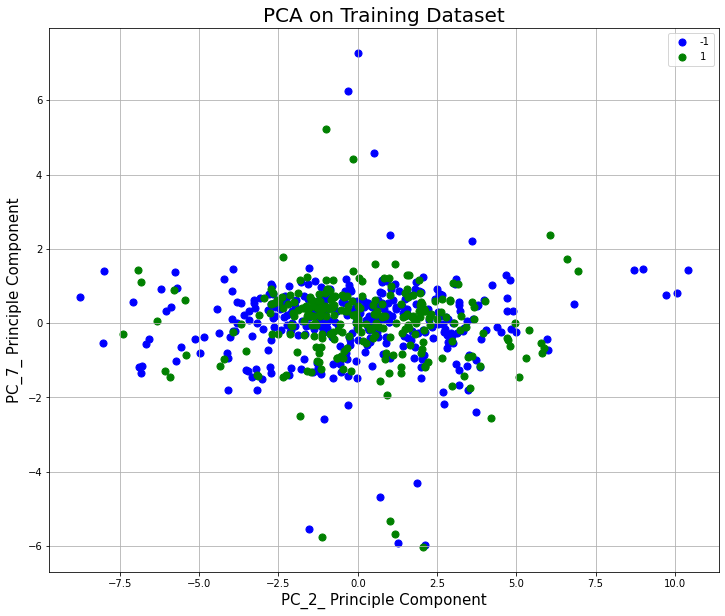

In [22]:
# Visualize Principle Components with Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1,1,1)
col_1 = "PC_2"
col_2 = "PC_7"
ax.set_xlabel(f"{col_1}_ Principle Component", fontsize=15)
ax.set_ylabel(f"{col_2}_ Principle Component", fontsize=15)
ax.set_title("PCA on Training Dataset", fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets, colors):
    indices_to_keep = y_train == target
    indices_to_keep = list(indices_to_keep)
    ax.scatter(df_pca.loc[indices_to_keep, col_1],
               df_pca.loc[indices_to_keep, col_2],
               c = color,
               s=50)
ax.legend(targets)
ax.grid()

### Supervised ML - Random Forest Classification

In [23]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.5757142857142857
Test Precision: 0.5570776255707762


In [24]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.51980535, 0.48019465],
       [0.58732137, 0.41267863],
       [0.56776239, 0.43223761],
       ...,
       [0.74221843, 0.25778157],
       [0.72348827, 0.27651173],
       [0.56116957, 0.43883043]])

In [25]:
# Test for Overfitting
train_scores, test_scores = list(), list()
values = [i for i in range(1, 200)]
for i in values:
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    
    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)
    
    # Test Data
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)

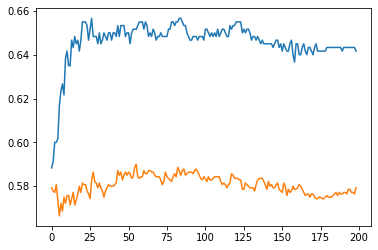

In [26]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()

### Conclusion

We have seen that by introducing PCA, we can dramatically reduce the amount of data required to train our supervised machine learning model (in this case Random Forest). One could further explore information provided by PCA by running K-Means clusters on the PCA data to find certain regimes in the data.

This is the fun part about machine learning, there are many ways to combine methods in the aim to optimize your strategy.

### Useful Resources and Reading

Use Case in Correlation for Stock Analysis: https://python.plainenglish.io/applying-pca-to-stocks-fbad2e51573f

Understanding the VIX: https://www.investopedia.com/stock-analysis/2012/4-ways-to-trade-the-vix-vxx-vxz-tvix-xxv0504.aspx

Using PCA in Forex Trading: 
https://deanstreetlab.github.io/papers/papers/FX%20Trading/Using%20a%20Principal%20Component%20Analysis%20for%20Multi-Currencies-Trading%20in%20the%20Foreign%20Exchange%20Market.pdf